# Multi-class semantic segmentation w/ Keras

This is a demostration jupyter notebook which purporse is to show how easy is to build simple semantic segmentation models even when having multiple classes.

Author: **Mario Salazar de Torres**

### Import libraries

In [1]:
%matplotlib inline

import os
import cv2
import json
import time
import math
import glob
import random
import numpy as np
from colorama import Fore
from matplotlib import cm
import matplotlib.pyplot as plt

### Dataset generation constant

In [2]:
# Generation
FIGURE_TYPES_NAMES = [
    'circle',
    'triangle',
    'quad',
    'pentagon'
]

MAX_FIGURES_COUNT = 19
IMAGE_SIZE = (512, 512)
FIGURES_GEN_EXCESS = 50
DISTANCE_SEPARATOR = 0.9
FIGURES_BOUNDARIES = (0.1, 0.9)
FIGURES_SPHERE_BOX_RADIUS = (0.025, 0.075)
FIGURES_SHAPES = (0,) + tuple(range(3, 6))
FIGURES_SHAPES_COUNT = len(FIGURES_SHAPES)

### Global model constants

In [3]:
#Encoder variables
MODEL_ENCODER_DROPOUT = 0.15
MODEL_ENCODER_POOLING = 'max'
MODEL_ENCODER_BRANCHES = (3, 7)
MODEL_ENCODER_ACTIVATION = 'tanh'
MODEL_ENCODER_LAYERS = (32, 64, 128)

#Decoder variables
MODEL_DECODER_DROPOUT = 0.15
MODEL_DECODER_BRANCHES = (3, 7)
MODEL_DECODER_ACTIVATION = 'tanh'
MODEL_DECODER_LAYERS = (128, 64, 32)

# Model variables
MODEL_INPUT_SHAPE = IMAGE_SIZE[::-1] + (1, )

### Model train constants

In [4]:
EPOCH_COUNT = 1 << 20

TRAIN_BATCH_SIZE = 6
TRAIN_STEPS_PER_EPOCH = 16

VALIDATION_BATCH_SIZE = 8
VALIDATION_STEPS_PER_EPOCH = 8

TEST_BATCH_SIZE = 16

MODEL_FILES_PATH = 'train'

CHECKPOINT_INTERVAL = 17
CHECKPOINT_PERIODIC_INTERVAL = 457
TENSORBOARD_DIR = MODEL_FILES_PATH
CHECKPOINT_PATH = os.path.join(MODEL_FILES_PATH, 'model-weights.h5')
CHECKPOINT_PERIODIC_PATH = os.path.join(MODEL_FILES_PATH, 'model-weights-periodic.{epoch:02d}-{val_loss:.2f}.h5')

### Generate figures

One of the things to highlight in this example is that dataset is synthetically generated. Main dataset characteristics are:
 - **512x512** grayscale input images
 - **512x512xN** output images being **N** the number of classes of to segmentate plus an unknown one.
 - This particular datasets consists of up to **19** figures, even none, of up to **4** types (*circles*, *triangles*, *quads* and *pentagons*)
 - Number of each figures per image are chosen from a multivariate [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).

One of the problems I faced to generate the dataset is to know how many possible figure distributions there are, so after a time researching I discovered the number of posibles ways to distribute *`m`* types of items into up to a total of *`n`* is described by [figurate numbers](https://en.wikipedia.org/wiki/Figurate_number). In this particular case the number of possibles distributions is given by *P<sub>4</sub>(n=19+1) = **8855***

Other problem is, in fact, to generate all possible possible distributions, so you are able to pickup any of them using a random uniform distribution later on. This is achieved by the recursive algorithm implemented in `GetPossibleDistributions`

Once you have all distributions and picked one of them the function used to draw it is `DrawDistribution` which randomly samples as many bounding circles as total number of figures in the particular distribution. That's done checking distance between bounding circles is greater than specified by `DISTANCE_SEPARATOR`. And lastly draw figures within its bounding circles.

In [5]:
def DrawPolygon(image, circle, sides):
    """Draws a polygon inscribed in the circle
    """
    
    (x, y), r = circle
    astep = 2*math.pi/sides
    alpha = 2*math.pi*random.random()
    points = np.array([(x + r*math.cos(alpha + astep*i), \
    y + r*math.sin(alpha + astep*i)) for i in range(sides)], np.int32)

    cv2.fillConvexPoly(image, points, 255)

def CircleCollides(c1, c2):
    """Checks whether or not 2 circles collides"""
    
    (x1, y1), r1 = c1
    (x2, y2), r2 = c2
    return (x1-x2)**2 + (y1-y2)**2 < (DISTANCE_SEPARATOR*(r1+r2))**2


def Collides(sbb, circle):
    """Checks whether or not circle collides with any in the list
    """

    for c in sbb:
        if CircleCollides(c, circle):
            return True

    return False


DrawMap = [
    lambda image, circle: cv2.circle(image, circle[0], circle[1], 255, -1),
    lambda image, circle: DrawPolygon(image, circle, 3),
    lambda image, circle: DrawPolygon(image, circle, 4),
    lambda image, circle: DrawPolygon(image, circle, 5)
]


def GetPossibleDistributions(n, k):
    """
        Get possible distributions for up to
        n-1 amount of figures and k figures types
    """
    
    stack = []

    def Recursion(l, s, v):
        """
            Recursion function
            @param l Recursion depth
            @param s Sum so far
            @param v Current item
        """

        if l > 0:
            for i in range(0, n-s):
                Recursion(l-1, s + i, v + [i,])
        else:
            stack.append(v)
            
        return stack

    return np.array(Recursion(k, 0, []), np.uint32)


def DrawDistribution(distro):
    """
    Draws a sample given its distribution
    :param distro: Figures distribution
    """

    sbb = []
    w, h = IMAGE_SIZE
    shapes = sum(distro)
    dd = (w*w + h*h)**0.5
    bb, ub = FIGURES_BOUNDARIES
    ngen = shapes*FIGURES_GEN_EXCESS
    rbb, rub = FIGURES_SPHERE_BOX_RADIUS
    image = np.zeros(IMAGE_SIZE[::-1] + (FIGURES_SHAPES_COUNT, ), np.uint8)

    while len(sbb) < shapes:
        radius = np.random.uniform(int(rbb*dd), int(rub*dd), \
                            ngen).astype(np.uint16).tolist()

        coords = np.random.uniform((int(bb*w), int(bb*h)), \
        (int(ub*w), int(ub*h)), (ngen, 2)).astype(np.uint16).tolist()

        for i in range(ngen):
            r = radius[i]
            p = tuple(coords[i])

            circle = (p, r)
            if not Collides(sbb, (p, r)):
                sbb.append(circle)

            if len(sbb) >= shapes:
                break

    count = 0
    for i in range(FIGURES_SHAPES_COUNT):
        draw = DrawMap[i]
        dst = np.zeros(IMAGE_SIZE[::-1], np.uint8)

        for j in range(distro[i]):
            draw(dst, sbb[count])
            count+=1

        image[:,:,i] = dst

    return image

In [6]:
SHAPES_DISTRIBUTIONS = GetPossibleDistributions(MAX_FIGURES_COUNT + 1, FIGURES_SHAPES_COUNT)

### Networks utilities

Some of this functions are layers initializations using PyTorch parametrization.

In [7]:
def KernelInitializer(seed=None):
    """
    Initializer with uniform distribution [-limit, limit] where limit = 1 / sqrt(fan_in)
    :param seed Initializer seed. If None is passed a random seed will be taken
    :return: A kernel initializer as of description says
    """

    from keras.initializers import VarianceScaling

    return VarianceScaling(scale=1./3.,
                           mode='fan_in',
                           distribution='uniform',
                           seed=seed)


def BnAffine(name=None, axis=-1):
    """
    Returns affine BN layer over last_channel
    :param name: Layer name
    :param axis: Which axis to perform BN over
    :return: Custom adjusted BN affine layer
    """

    from keras.layers import BatchNormalization
    from keras.initializers import RandomUniform

    return BatchNormalization(momentum=0.1, epsilon=1e-5,
    gamma_initializer=RandomUniform(0, 1), axis=axis, name=name)


def SqrConv2D(neurons, ksize, activation=None, name=None):
    """
    Square kernel 2D convolution
    :param neurons: Number of convolution channels
    :param ksize: Convolution kernel size
    :param activation: Layer activation. If None is passed, it will use no activation
    :param name: Layer name
    :return: Custom adjusted 2D square convolutional layer 
    """

    from keras.layers import Conv2D

    return Conv2D(neurons, (ksize, ksize), kernel_initializer=KernelInitializer(),
    bias_initializer=KernelInitializer(), padding='same', activation=activation, name=name)


def SqrDeconv2D(neurons, ksize, activation=None, name=None):
    """
    Square kernel 2D deconvolution
    :param neurons: Number of deconvolution channels
    :param ksize: Deconvolution kernel size
    :param activation: Layer activation. If None is passed, it will use no activation
    :param name: Layer name
    :return: Custom adjusted 2D square deconvolutional layer 
    """

    from keras.layers import Conv2DTranspose

    return Conv2DTranspose(neurons, (ksize, ksize), kernel_initializer=KernelInitializer(),
    bias_initializer=KernelInitializer(), padding='same', activation=activation, name=name)

### Build encoder model

This is first part of the semantic segmentation model, the encoder, which reduce all the visual information compressing it into a map of convolutional features. Encoder uses a multi-size convolutional kernel features and merge it all with a residual block.

In [8]:
def EncoderResBlock(layers):
    """
    Makes residual operation for image model

    :param layers: Layers to connect with residual block
    """
    
    import tensorflow as tf

    inp = layers[0]
    concat = tf.concat(layers[1:], -1)
    mult = int(concat.shape[-1]) // int(inp.shape[-1])

    return concat + tf.tile(inp, [1, 1, 1, mult])


def DefineModelEncoder(shape,
                       pool=MODEL_ENCODER_POOLING,
                       layers=MODEL_ENCODER_LAYERS,
                       branches=MODEL_ENCODER_BRANCHES,
                       actfn=MODEL_ENCODER_ACTIVATION,
                       dropout=MODEL_ENCODER_DROPOUT,
                       name='encoder'):
    """
    Defines model encoder
    :param shape: Input shape
    :param pool: Pooling method: avg or max
    :param layers: Number of channels per layer
    :param branches: Kernel-size per layer
    :param actfn: Activation function
    :param dropout: Dropout percentage
    :param name: Model block name
    """

    from keras.models import Model
    from keras.layers import Input, Lambda, Concatenate, \
        Dropout, MaxPooling2D, AveragePooling2D, Activation

    x = inp = Input(shape=shape, name='%s_input' % name)
    Pooling2D = MaxPooling2D if pool == 'max' else AveragePooling2D
    
    for i, neurons in enumerate(layers):

        pnames = (name, i)
        btensors = [SqrConv2D(neurons, k, 
        name='%s_block%u_branch%ux%u' % (pnames + (k, k)))(x) for k in branches]
        
        if i:
            concat = Lambda(EncoderResBlock, name='%s_block%u_concat' % pnames)([x,] + btensors)
        else:
            concat = Concatenate(name='%s_block%u_concat' % pnames)(btensors)

        bn = BnAffine(name='%s_block%u_bn' % pnames)(concat)
        activation = Activation(actfn, name='%s_block%u_activation' % pnames)(bn)
        pool = Pooling2D(name='%s_block%u_pool' % pnames)(activation)
        x = Dropout(dropout, name='%s_block%u_dropout' % pnames)(pool)

    return Model(inputs=inp, outputs=x, name=name)

### Build decoder model

This is last part of the semantic segmentation model, the decoder, which expands learned feature map to generate the channel-split segmentation. Decoder uses a multi-size convolutional kernel features and merge it all with a residual block. Its last layer is a 3x3 convolutional layer with as many channels as classes (**4+1**), *sigmoid* activated.

Take in mind that activation for the last layer is important as of it could restrict certains behaviours. For example If last activation where a *softmax* instead, classes overlappings wouldn't be detected.

In [9]:
def DecoderResBlock(layers):
    """
    Makes residual operation for image model

    :param layers: Layers to connect with residual block
    """
    
    import tensorflow as tf

    inp = layers[0]
    concat = tf.concat(layers[1:], -1)
    mult = int(inp.shape[-1]) // int(concat.shape[-1])
    residual = tf.add_n([inp[:,:,:, i::mult] \
                    for i in range(mult)]) / float(mult)

    return concat + residual


def DefineModelDecoder(shape,
                       layers=MODEL_DECODER_LAYERS,
                       branches=MODEL_DECODER_BRANCHES,
                       actfn=MODEL_DECODER_ACTIVATION,
                       dropout=MODEL_DECODER_DROPOUT,
                       name='decoder'):
    """
    Defines model decoder
    :param shape: Input shape
    :param layers: Number of channels per layer
    :param branches: Kernel-size per layer
    :param actfn: Activation function
    :param dropout: Dropout percentage
    :param name: Model block name
    """

    from keras.models import Model
    from keras.layers import Input, Lambda, Reshape, UpSampling2D, Dropout, \
                                                  TimeDistributed, Activation

    x = inp = Input(shape=shape, name='%s_input' % name)
    
    for i, neurons in enumerate(layers):

        pnames = (name, i)
        btensors = [SqrDeconv2D(neurons, k, 
        name='%s_block%u_branch%ux%u' % (pnames + (k, k)))(x) for k in branches]
        concat = Lambda(DecoderResBlock, name='%s_block%u_concat' % pnames)([x,] + btensors)

        bn = BnAffine(name='%s_block%u_bn' % pnames)(concat)
        activation = Activation(actfn, name='%s_block%u_activation' % pnames)(bn)
        pool = UpSampling2D(name='%s_block%u_pool' % pnames)(activation)
        x = Dropout(dropout, name='%s_block%u_dropout' % pnames)(pool)

    pnames = (name, i+1)
    x = SqrDeconv2D(FIGURES_SHAPES_COUNT + 1, 3, name='%s_block%u_branch3x3' % pnames)(x)
    x = BnAffine(name='%s_block%u_bn' % pnames)(x)
    x = Activation('sigmoid', name='%s_block%u_activation' % pnames)(x)

    return Model(inputs=inp, outputs=x, name=name)

### Define the model

There are several considerations to have in mind about the model, like:
 - All inputs/outputs are **[0, 1]** normalized.
 - Activation functions (except for last) are **tanh**.
 - All layer blocks uses batch normalization and dropout.

In [10]:
def DefineModel(name='segmentation'):
    """
    Segmentation model

    :param name: Model name
    """
    
    from keras.models import Model
    from keras.layers import Input
    from keras.optimizers import Adadelta
    
    inp = Input(shape=MODEL_INPUT_SHAPE, name='%s_input' % name)
    
    encoder = DefineModelEncoder(MODEL_INPUT_SHAPE)
    decoder = DefineModelDecoder(encoder.output_shape[1:])

    opt = Adadelta(lr=7e-1, decay=1e-6, rho=0.9)
    model = Model(inputs=inp, outputs=decoder(encoder(inp)), name=name)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc', 'mse'])
    
    return model

### Load the model

In [11]:
model = DefineModel()
model.summary()

try:
    print('[INFO] Trying to load model weights...')
    model.load_weights(CHECKPOINT_PATH)
    print('[INFO] Successfully loaded model weights.')
except Exception as e:
    print('[ERROR] Failure while loading the model weights.')
    print(e)

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
segmentation_input (InputLay (None, 512, 512, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 64, 64, 256)       1191936   
_________________________________________________________________
decoder (Model)              (None, 512, 512, 5)       3093529   
Total params: 4,285,465
Trainable params: 4,283,663
Non-trainable params: 1,802
_________________________________________________________________
[INFO] Trying to load model weights...
[INFO] Successfully loaded model weights.


### Define callbacks

In [12]:
def LoadCallbacks(init_epoch=0):
    """
    Loads callbacks

    :param init_epoch: Initial epoch
    """

    from keras.callbacks import Callback, TensorBoard, ModelCheckpoint

    class EpochCallback(Callback):

        def __init__(self, epoch=0):
            Callback.__init__(self)
            self.epoch = epoch


        def on_epoch_end(self, epoch, logs={}):
            self.epoch = epoch

    try: # Create model path
        os.makedirs(MODEL_FILES_PATH)
    except OSError:
        pass

    return [EpochCallback(init_epoch), ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, 
            save_best_only=True, mode='min', save_weights_only=True, period=CHECKPOINT_INTERVAL),
            ModelCheckpoint(CHECKPOINT_PERIODIC_PATH, monitor='loss', verbose=1,
            mode='min', save_weights_only=True, period=CHECKPOINT_PERIODIC_INTERVAL),
            TensorBoard(log_dir=TENSORBOARD_DIR)
           ]

### Define generator

In [13]:
def Generator(batchsize):
    """
    Dataset generator

    :param batchsize: Mini-batch size
    """

    inorm = 1.0/255.0
    X = np.zeros((batchsize, ) + IMAGE_SIZE[::-1] + (1,), np.float32)
    Y = np.zeros((batchsize, ) + IMAGE_SIZE[::-1] + (FIGURES_SHAPES_COUNT + 1, ), np.float32)

    while True:

        # Generate negative samples
        for i in range(batchsize):
            img = np.zeros(IMAGE_SIZE[::-1] + (1,), np.uint8)
            distro = random.choice(SHAPES_DISTRIBUTIONS)
            mask = DrawDistribution(distro)

            for j in range(FIGURES_SHAPES_COUNT):
                img|=mask[:,:,j:j+1]

            X[i] = img
            Y[i] = np.concatenate((mask, ~img), axis=-1)

        yield X*inorm, Y*inorm

### Initialize train variables

In [14]:
callbacks = LoadCallbacks(853)

### Initialize generators

In [15]:
test_generator = Generator(TEST_BATCH_SIZE)
train_generator = Generator(TRAIN_BATCH_SIZE)
validation_generator = Generator(VALIDATION_BATCH_SIZE)

### Train model

In [24]:
model.fit_generator(train_generator,
                steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                validation_data=validation_generator,
                validation_steps=VALIDATION_STEPS_PER_EPOCH,
                epochs=EPOCH_COUNT,
                verbose=1,
                initial_epoch=callbacks[0].epoch,
                callbacks=callbacks
         )

Epoch 898/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0038 - acc: 0.9990 - mean_squared_error: 7.7828e-04 - val_loss: 0.0039 - val_acc: 0.9990 - val_mean_squared_error: 7.4525e-04
Epoch 899/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0041 - acc: 0.9989 - mean_squared_error: 8.2307e-04 - val_loss: 0.0033 - val_acc: 0.9993 - val_mean_squared_error: 5.7549e-04
Epoch 900/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0039 - acc: 0.9990 - mean_squared_error: 7.7872e-04 - val_loss: 0.0031 - val_acc: 0.9992 - val_mean_squared_error: 5.6515e-04
Epoch 901/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0040 - acc: 0.9990 - mean_squared_error: 7.8778e-04 - val_loss: 0.0031 - val_acc: 0.9992 - val_mean_squared_error: 5.8182e-04
Epoch 902/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0038 - acc: 0.9990 - mean_squared_error: 7.5421e-04 - val_loss: 0.0034 - val_acc: 0.9992 - 

16/16 [==============================] - 43s 3s/step - loss: 0.0043 - acc: 0.9989 - mean_squared_error: 8.7396e-04 - val_loss: 0.0037 - val_acc: 0.9990 - val_mean_squared_error: 7.5019e-04

Epoch 00937: val_loss did not improve
Epoch 938/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.6843e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.0630e-04
Epoch 939/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.6413e-04 - val_loss: 0.0034 - val_acc: 0.9991 - val_mean_squared_error: 6.7547e-04
Epoch 940/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.4671e-04 - val_loss: 0.0028 - val_acc: 0.9993 - val_mean_squared_error: 5.2400e-04
Epoch 941/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.6184e-04 - val_loss: 0.0265

Epoch 976/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9991 - mean_squared_error: 7.1134e-04 - val_loss: 0.0028 - val_acc: 0.9993 - val_mean_squared_error: 5.4705e-04
Epoch 977/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.2355e-04 - val_loss: 0.0028 - val_acc: 0.9993 - val_mean_squared_error: 5.6768e-04
Epoch 978/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0036 - acc: 0.9990 - mean_squared_error: 7.3571e-04 - val_loss: 0.0029 - val_acc: 0.9992 - val_mean_squared_error: 5.7757e-04
Epoch 979/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.6378e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.5069e-04
Epoch 980/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.5525e-04 - val_loss: 0.0029 - val_acc: 0.9993 - 

Epoch 1015/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0042 - acc: 0.9989 - mean_squared_error: 8.7857e-04 - val_loss: 0.0028 - val_acc: 0.9992 - val_mean_squared_error: 5.7092e-04
Epoch 1016/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0034 - acc: 0.9990 - mean_squared_error: 7.1303e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.4316e-04
Epoch 1017/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9991 - mean_squared_error: 7.1168e-04 - val_loss: 0.0024 - val_acc: 0.9994 - val_mean_squared_error: 4.4509e-04
Epoch 1018/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.3439e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.0541e-04
Epoch 1019/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.3503e-04 - val_loss: 0.0030 - val_acc: 0.99

16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9989 - mean_squared_error: 7.8808e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.3827e-04
Epoch 1055/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0034 - acc: 0.9990 - mean_squared_error: 7.2543e-04 - val_loss: 0.0025 - val_acc: 0.9994 - val_mean_squared_error: 5.0093e-04
Epoch 1056/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0034 - acc: 0.9990 - mean_squared_error: 7.1577e-04 - val_loss: 0.0032 - val_acc: 0.9992 - val_mean_squared_error: 6.3115e-04

Epoch 01056: val_loss did not improve
Epoch 1057/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0036 - acc: 0.9990 - mean_squared_error: 7.5895e-04 - val_loss: 0.0028 - val_acc: 0.9993 - val_mean_squared_error: 5.5295e-04
Epoch 1058/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.3550e-04 - val_loss: 0.

Epoch 1093/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0032 - acc: 0.9991 - mean_squared_error: 6.9503e-04 - val_loss: 0.0025 - val_acc: 0.9994 - val_mean_squared_error: 4.9785e-04
Epoch 1094/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 7.0952e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.2903e-04
Epoch 1095/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.3169e-04 - val_loss: 0.0028 - val_acc: 0.9992 - val_mean_squared_error: 5.8952e-04
Epoch 1096/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0034 - acc: 0.9990 - mean_squared_error: 7.3180e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.3066e-04
Epoch 1097/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9990 - mean_squared_error: 7.5206e-04 - val_loss: 0.0026 - val_acc: 0.99

Epoch 1132/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0032 - acc: 0.9991 - mean_squared_error: 6.7453e-04 - val_loss: 0.0027 - val_acc: 0.9992 - val_mean_squared_error: 5.8382e-04
Epoch 1133/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0037 - acc: 0.9990 - mean_squared_error: 7.8855e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.6555e-04
Epoch 1134/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 7.1188e-04 - val_loss: 0.0023 - val_acc: 0.9994 - val_mean_squared_error: 4.7267e-04
Epoch 1135/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0032 - acc: 0.9991 - mean_squared_error: 6.8503e-04 - val_loss: 0.0023 - val_acc: 0.9994 - val_mean_squared_error: 4.7886e-04
Epoch 1136/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.3463e-04 - val_loss: 0.0023 - val_acc: 0.99

Epoch 1171/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0031 - acc: 0.9991 - mean_squared_error: 6.6914e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.6667e-04
Epoch 1172/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.4716e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.5990e-04
Epoch 1173/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0040 - acc: 0.9989 - mean_squared_error: 8.9569e-04 - val_loss: 0.0044 - val_acc: 0.9989 - val_mean_squared_error: 9.6919e-04
Epoch 1174/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 7.2151e-04 - val_loss: 0.0022 - val_acc: 0.9995 - val_mean_squared_error: 4.2564e-04
Epoch 1175/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0031 - acc: 0.9991 - mean_squared_error: 6.6927e-04 - val_loss: 0.0030 - val_acc: 0.99


Epoch 01209: val_loss did not improve
Epoch 1210/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0032 - acc: 0.9991 - mean_squared_error: 7.0364e-04 - val_loss: 0.0023 - val_acc: 0.9994 - val_mean_squared_error: 4.5922e-04
Epoch 1211/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.6604e-04 - val_loss: 0.0021 - val_acc: 0.9995 - val_mean_squared_error: 4.1649e-04
Epoch 1212/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9992 - mean_squared_error: 6.2888e-04 - val_loss: 0.0024 - val_acc: 0.9994 - val_mean_squared_error: 4.4475e-04
Epoch 1213/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 7.2149e-04 - val_loss: 0.0058 - val_acc: 0.9982 - val_mean_squared_error: 0.0014
Epoch 1214/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0051 - acc: 0.9985 - mean_squared_error: 0.0011 - v

Epoch 1249/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0032 - acc: 0.9991 - mean_squared_error: 7.0492e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.2728e-04
Epoch 1250/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.5795e-04 - val_loss: 0.0024 - val_acc: 0.9994 - val_mean_squared_error: 4.9545e-04
Epoch 1251/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.4977e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.5225e-04
Epoch 1252/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.3867e-04 - val_loss: 0.0023 - val_acc: 0.9993 - val_mean_squared_error: 4.9281e-04
Epoch 1253/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.0385e-04 - val_loss: 0.0023 - val_acc: 0.99

16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.4808e-04 - val_loss: 0.0022 - val_acc: 0.9994 - val_mean_squared_error: 4.3882e-04
Epoch 1289/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.0722e-04 - val_loss: 0.0024 - val_acc: 0.9994 - val_mean_squared_error: 5.1129e-04
Epoch 1290/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.5157e-04 - val_loss: 0.0025 - val_acc: 0.9993 - val_mean_squared_error: 5.1839e-04
Epoch 1291/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9992 - mean_squared_error: 6.2563e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.4496e-04
Epoch 1292/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.4680e-04 - val_loss: 0.0020 - val_acc: 0.9995 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 5.9164e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.3700e-04
Epoch 1327/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9991 - mean_squared_error: 6.2872e-04 - val_loss: 0.0020 - val_acc: 0.9995 - val_mean_squared_error: 4.1779e-04
Epoch 1328/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.4808e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.5095e-04

Epoch 01328: val_loss did not improve
Epoch 1329/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0033 - acc: 0.9990 - mean_squared_error: 7.2497e-04 - val_loss: 0.0023 - val_acc: 0.9994 - val_mean_squared_error: 4.8035e-04
Epoch 1330/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.2488e-04 - val_loss: 0.

Epoch 1365/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9991 - mean_squared_error: 6.3620e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squared_error: 4.0183e-04
Epoch 1366/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9991 - mean_squared_error: 6.3369e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.5204e-04
Epoch 1367/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.1030e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squared_error: 3.9284e-04
Epoch 1368/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.0856e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.6376e-04
Epoch 1369/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.1834e-04 - val_loss: 0.0020 - val_acc: 0.99

16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.0892e-04 - val_loss: 0.0021 - val_acc: 0.9995 - val_mean_squared_error: 4.2443e-04
Epoch 1405/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0031 - acc: 0.9991 - mean_squared_error: 7.0421e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.4447e-04
Epoch 1406/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2079e-04 - val_loss: 0.0033 - val_acc: 0.9991 - val_mean_squared_error: 6.6976e-04
Epoch 1407/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.2179e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.6759e-04
Epoch 1408/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.4625e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0030 - acc: 0.9991 - mean_squared_error: 6.6633e-04 - val_loss: 0.0026 - val_acc: 0.9993 - val_mean_squared_error: 5.0687e-04
Epoch 1444/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.6805e-04 - val_loss: 0.0030 - val_acc: 0.9992 - val_mean_squared_error: 6.2861e-04
Epoch 1445/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.1164e-04 - val_loss: 0.0035 - val_acc: 0.9990 - val_mean_squared_error: 7.3507e-04
Epoch 1446/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.5627e-04 - val_loss: 0.0022 - val_acc: 0.9994 - val_mean_squared_error: 4.4846e-04
Epoch 1447/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 5.9988e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.0633e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squared_error: 4.1119e-04
Epoch 1483/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.4372e-04 - val_loss: 0.0020 - val_acc: 0.9995 - val_mean_squared_error: 3.9485e-04
Epoch 1484/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 5.9482e-04 - val_loss: 0.0022 - val_acc: 0.9993 - val_mean_squared_error: 4.9949e-04
Epoch 1485/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.6074e-04 - val_loss: 0.0022 - val_acc: 0.9994 - val_mean_squared_error: 4.7850e-04
Epoch 1486/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2221e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squar

Epoch 1521/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0028 - acc: 0.9992 - mean_squared_error: 6.2735e-04 - val_loss: 0.0026 - val_acc: 0.9995 - val_mean_squared_error: 4.3916e-04
Epoch 1522/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8516e-04 - val_loss: 0.0020 - val_acc: 0.9994 - val_mean_squared_error: 4.1656e-04
Epoch 1523/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.1042e-04 - val_loss: 0.0023 - val_acc: 0.9993 - val_mean_squared_error: 5.0984e-04
Epoch 1524/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2511e-04 - val_loss: 0.0022 - val_acc: 0.9994 - val_mean_squared_error: 4.8369e-04
Epoch 1525/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2087e-04 - val_loss: 0.0017 - val_acc: 0.99

16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2678e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.9818e-04
Epoch 1561/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 5.9833e-04 - val_loss: 0.0020 - val_acc: 0.9994 - val_mean_squared_error: 4.5743e-04
Epoch 1562/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.0420e-04 - val_loss: 0.0023 - val_acc: 0.9994 - val_mean_squared_error: 4.7892e-04
Epoch 1563/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.1497e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.8127e-04
Epoch 1564/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2271e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.1239e-04 - val_loss: 0.0020 - val_acc: 0.9994 - val_mean_squared_error: 4.2588e-04
Epoch 1600/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.1303e-04 - val_loss: 0.0027 - val_acc: 0.9993 - val_mean_squared_error: 5.6540e-04

Epoch 01600: val_loss did not improve
Epoch 1601/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2804e-04 - val_loss: 0.0019 - val_acc: 0.9995 - val_mean_squared_error: 4.2043e-04
Epoch 1602/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.7776e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.5608e-04
Epoch 1603/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.1311e-04 - val_loss: 0.

16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 5.9343e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.5018e-04
Epoch 1638/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9993 - mean_squared_error: 5.5212e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.6846e-04
Epoch 1639/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8637e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.9640e-04
Epoch 1640/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 5.9867e-04 - val_loss: 0.0017 - val_acc: 0.9996 - val_mean_squared_error: 3.5378e-04
Epoch 1641/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.7654e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9993 - mean_squared_error: 5.5092e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.7378e-04
Epoch 1677/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8600e-04 - val_loss: 0.0018 - val_acc: 0.9994 - val_mean_squared_error: 4.1289e-04
Epoch 1678/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.2231e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.9782e-04
Epoch 1679/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8675e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.4595e-04
Epoch 1680/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9992 - mean_squared_error: 6.1439e-04 - val_loss: 0.0022 - val_acc: 0.9994 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8536e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.7250e-04
Epoch 1716/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.4307e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.6695e-04
Epoch 1717/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.0976e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.8870e-04
Epoch 1718/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.3778e-04 - val_loss: 0.0020 - val_acc: 0.9994 - val_mean_squared_error: 4.2684e-04
Epoch 1719/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.5426e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squar

16/16 [==============================] - 43s 3s/step - loss: 0.0035 - acc: 0.9989 - mean_squared_error: 7.9782e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.9964e-04
Epoch 1755/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0027 - acc: 0.9991 - mean_squared_error: 6.5137e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.8825e-04
Epoch 1756/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.7811e-04 - val_loss: 0.0019 - val_acc: 0.9994 - val_mean_squared_error: 4.1630e-04
Epoch 1757/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0026 - acc: 0.9992 - mean_squared_error: 6.0439e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 4.0557e-04
Epoch 1758/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.7604e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squar

Epoch 1793/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.4414e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.6953e-04
Epoch 1794/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9992 - mean_squared_error: 5.6050e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.5201e-04
Epoch 1795/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8953e-04 - val_loss: 0.0016 - val_acc: 0.9996 - val_mean_squared_error: 3.3899e-04
Epoch 1796/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.8070e-04 - val_loss: 0.0017 - val_acc: 0.9996 - val_mean_squared_error: 3.5681e-04
Epoch 1797/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.8297e-04 - val_loss: 0.0016 - val_acc: 0.99

Epoch 1832/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.5622e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.6431e-04
Epoch 1833/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.5035e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.5903e-04
Epoch 1834/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.4723e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.6254e-04
Epoch 1835/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9992 - mean_squared_error: 5.5353e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.5649e-04
Epoch 1836/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0025 - acc: 0.9992 - mean_squared_error: 5.9433e-04 - val_loss: 0.0016 - val_acc: 0.99

Epoch 1871/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.4462e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.6479e-04
Epoch 1872/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.3581e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.6394e-04

Epoch 01872: val_loss did not improve
Epoch 1873/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.6630e-04 - val_loss: 0.0021 - val_acc: 0.9994 - val_mean_squared_error: 4.7456e-04
Epoch 1874/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0023 - acc: 0.9993 - mean_squared_error: 5.4262e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 3.8539e-04
Epoch 1875/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.6900

16/16 [==============================] - 43s 3s/step - loss: 0.0022 - acc: 0.9993 - mean_squared_error: 5.2574e-04 - val_loss: 0.0017 - val_acc: 0.9995 - val_mean_squared_error: 3.7561e-04
Epoch 1910/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0022 - acc: 0.9993 - mean_squared_error: 5.4128e-04 - val_loss: 0.0016 - val_acc: 0.9995 - val_mean_squared_error: 3.6310e-04
Epoch 1911/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0022 - acc: 0.9993 - mean_squared_error: 5.2148e-04 - val_loss: 0.0015 - val_acc: 0.9996 - val_mean_squared_error: 3.3776e-04
Epoch 1912/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0024 - acc: 0.9992 - mean_squared_error: 5.8086e-04 - val_loss: 0.0018 - val_acc: 0.9995 - val_mean_squared_error: 4.0192e-04
Epoch 1913/1048576
16/16 [==============================] - 43s 3s/step - loss: 0.0029 - acc: 0.9991 - mean_squared_error: 6.7397e-04 - val_loss: 0.0025 - val_acc: 0.9995 - val_mean_squar

KeyboardInterrupt: 

In [ ]:
model.save_weights(CHECKPOINT_PATH)

### Test the model

In [21]:
cmap = cm.get_cmap('nipy_spectral_r')
ymask = np.zeros(IMAGE_SIZE[::-1] + (3,), np.uint8)
ymaskpred = np.zeros(IMAGE_SIZE[::-1] + (3,), np.uint8)
colors = np.array([cmap(float(i)/FIGURES_SHAPES_COUNT)[:3] \
                    for i in range(FIGURES_SHAPES_COUNT+1)])

[INFO] Time delta is 1.8013


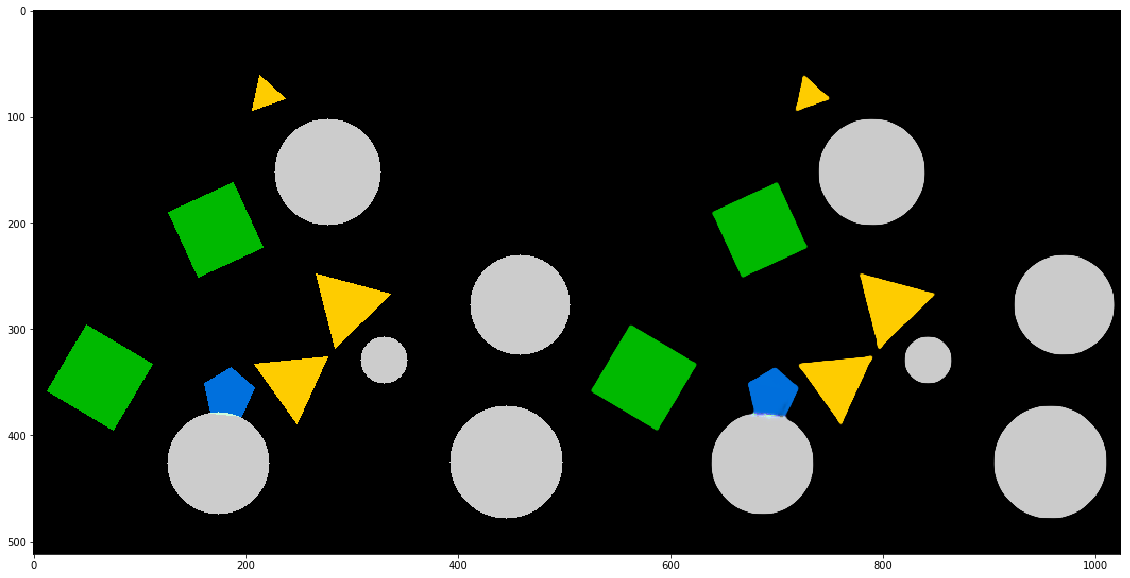

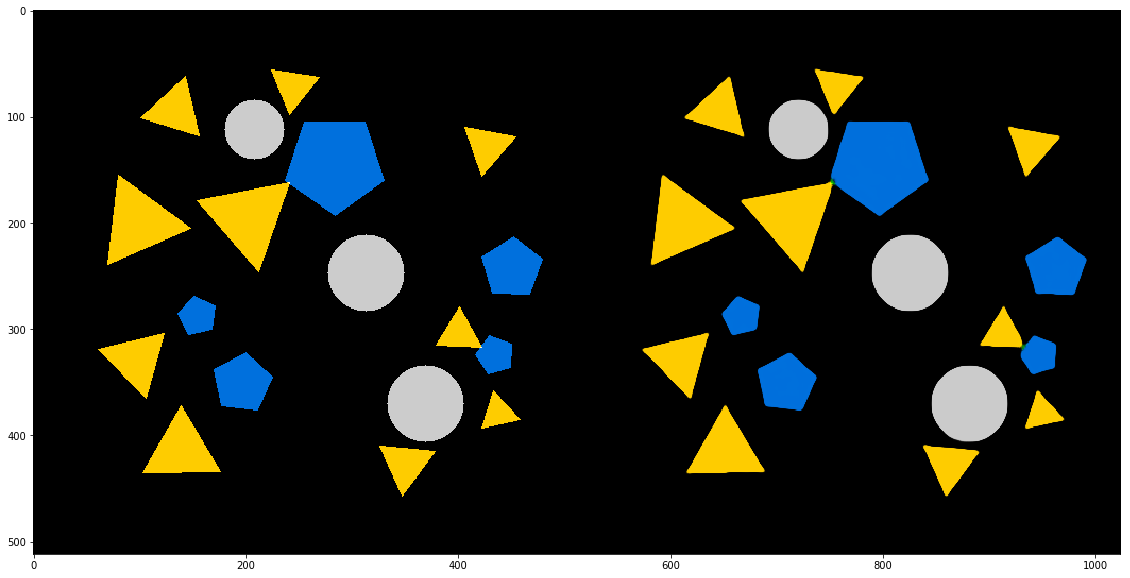

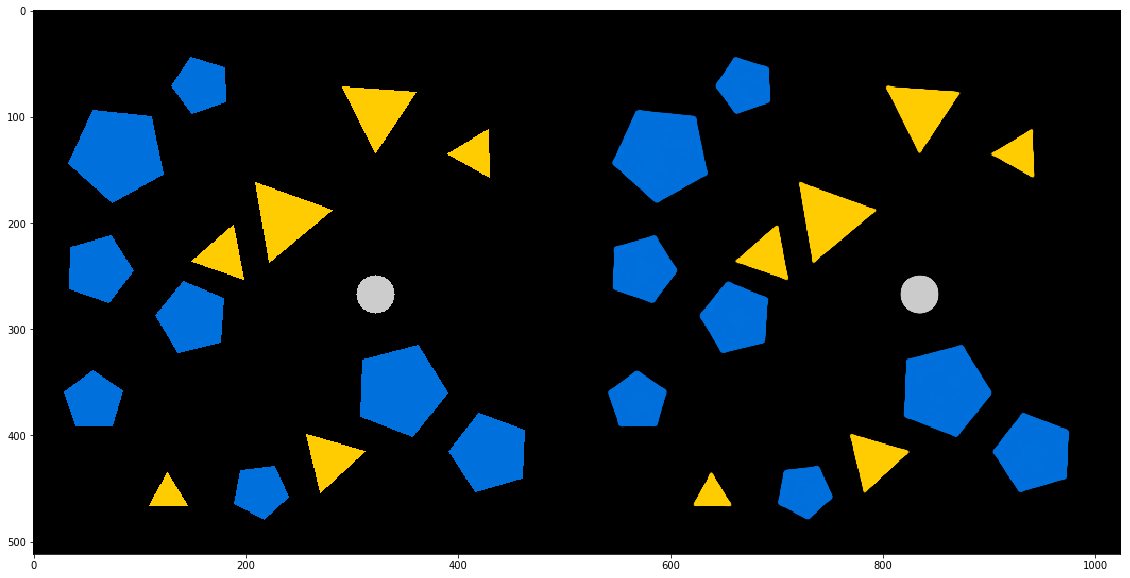

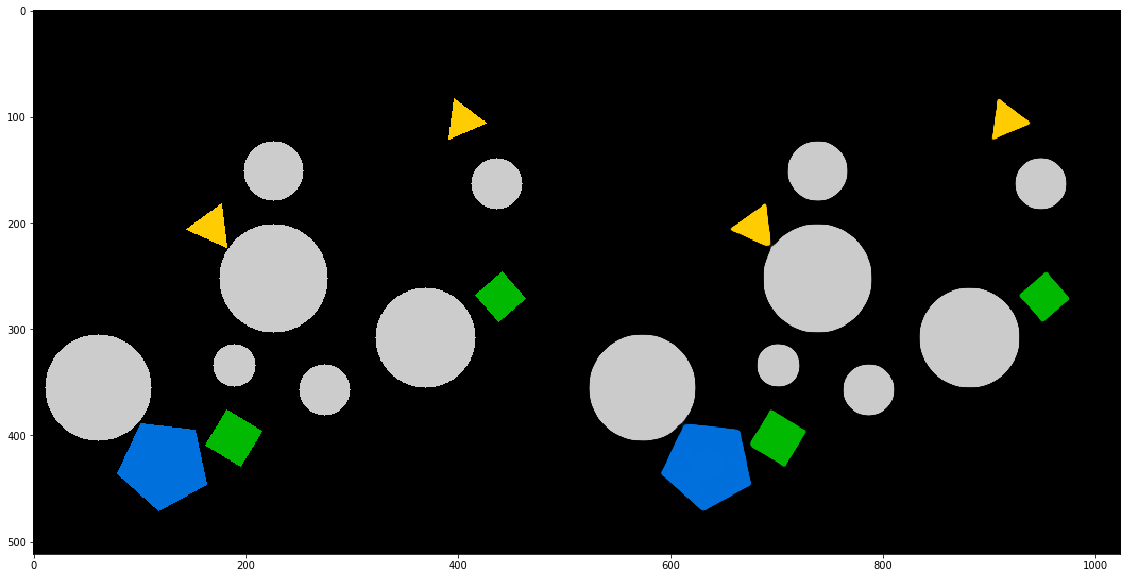

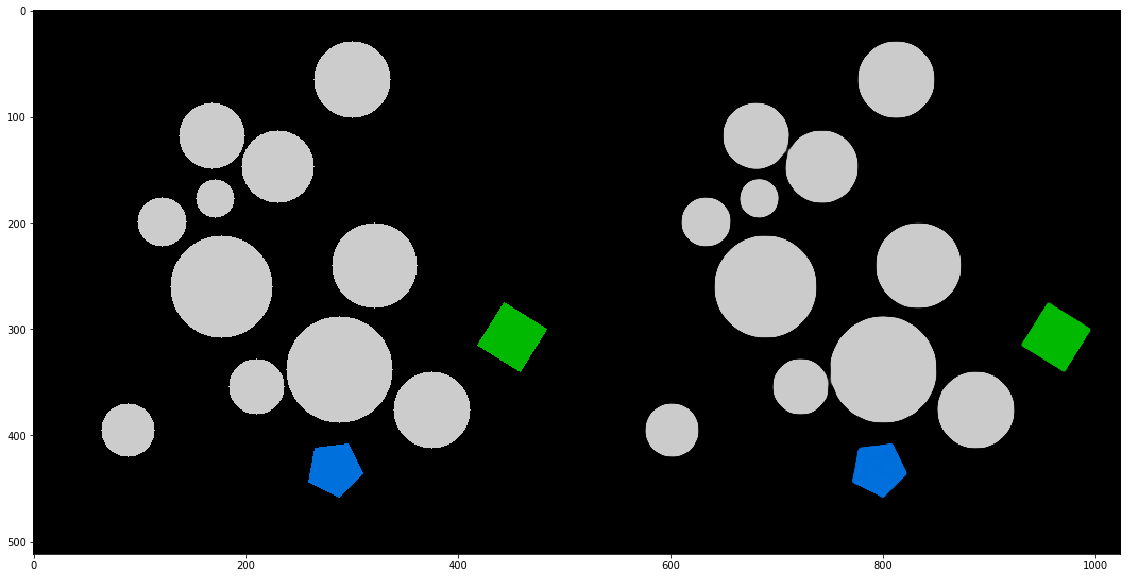

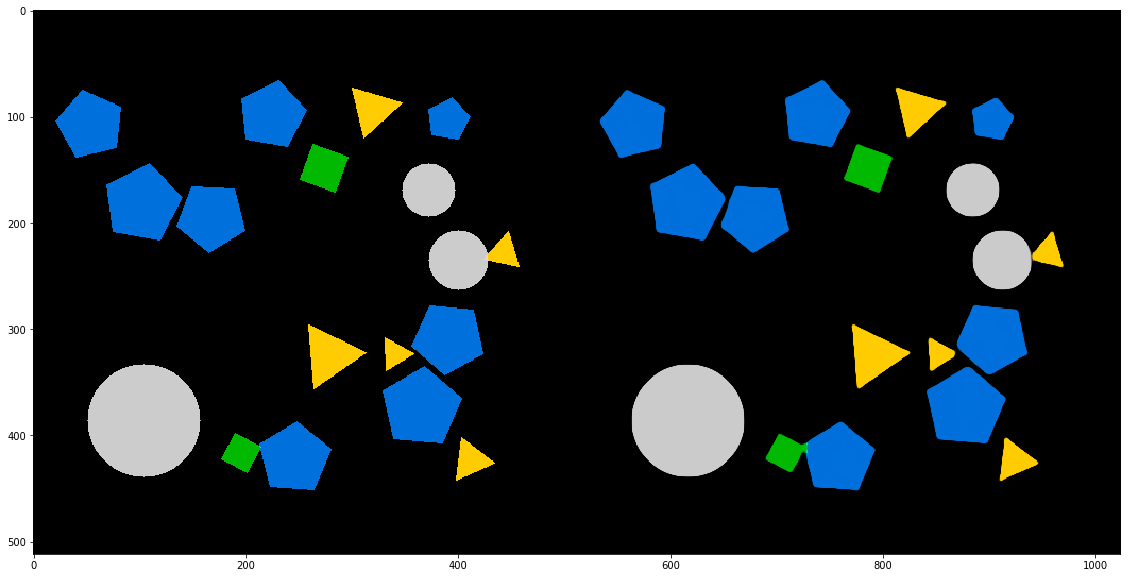

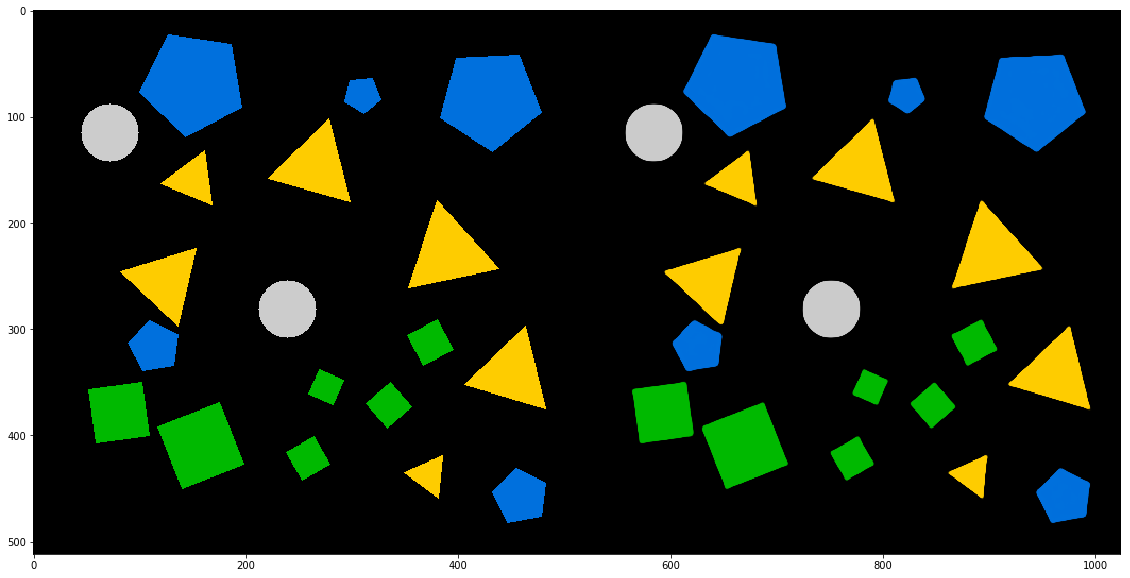

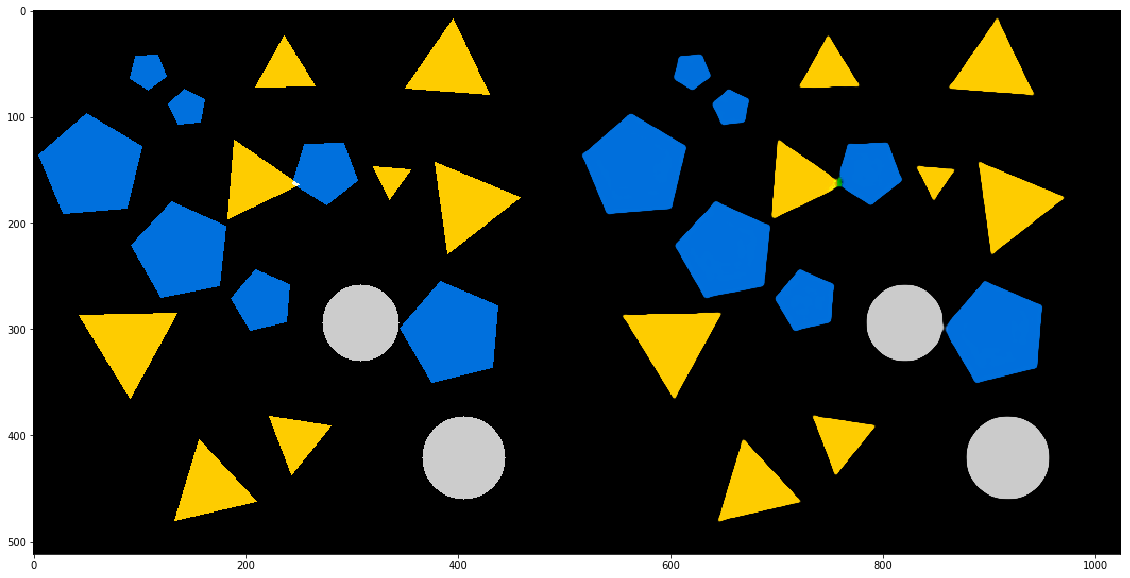

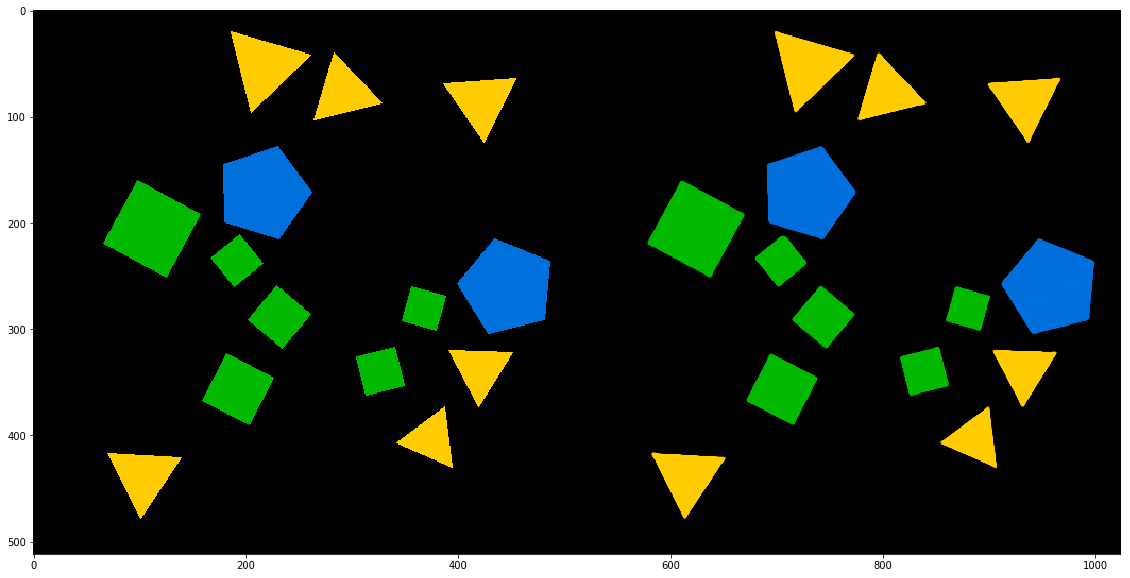

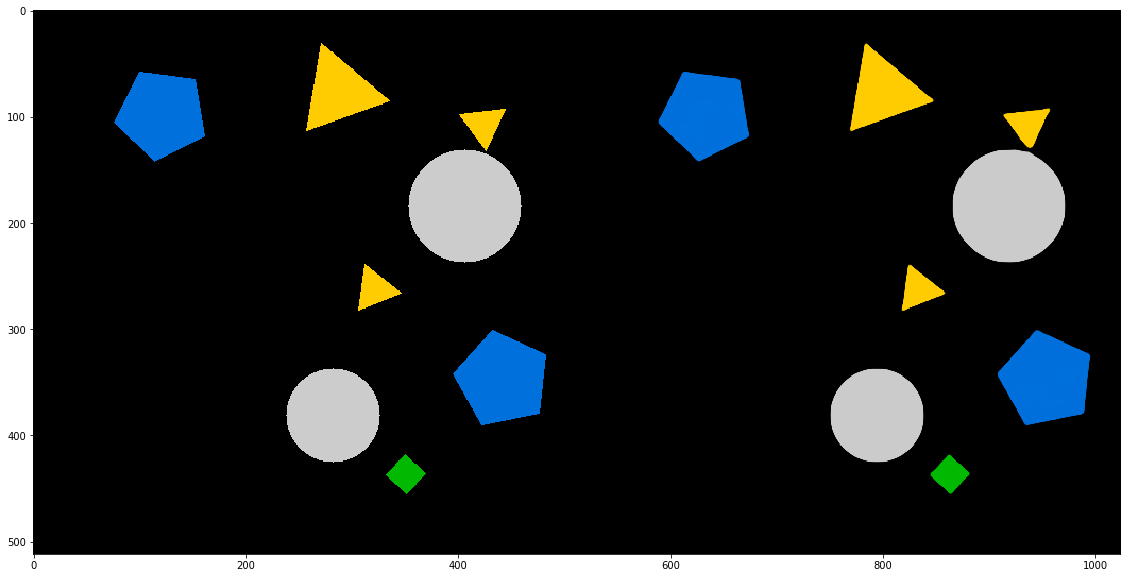

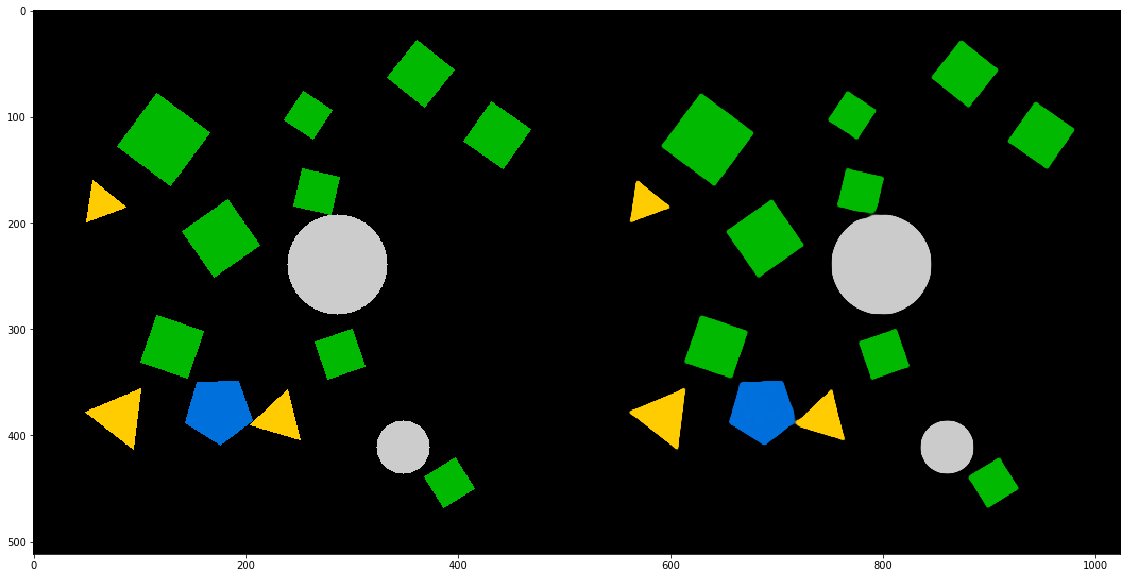

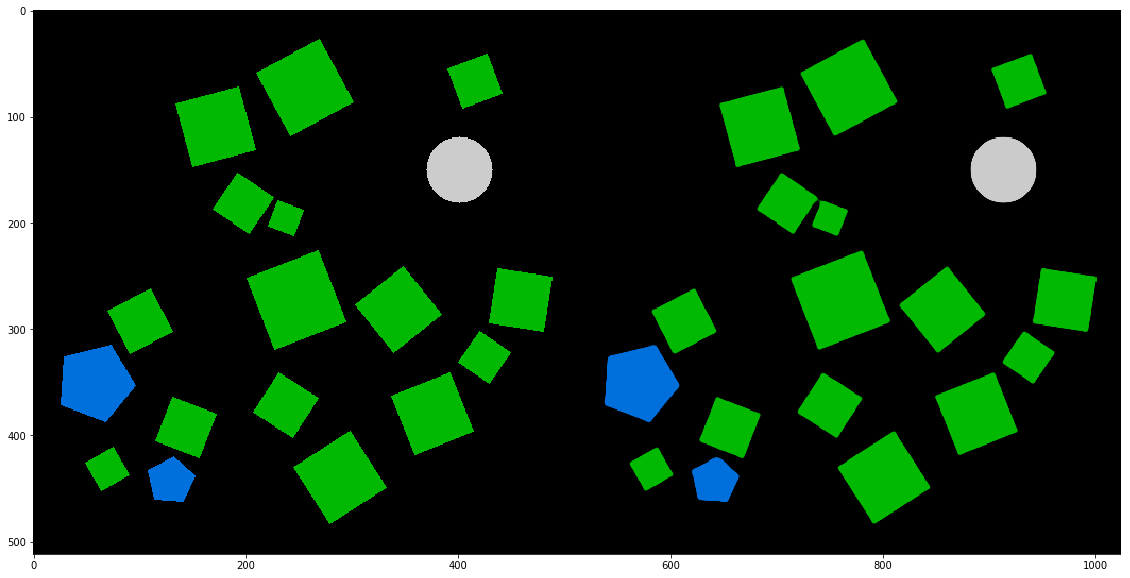

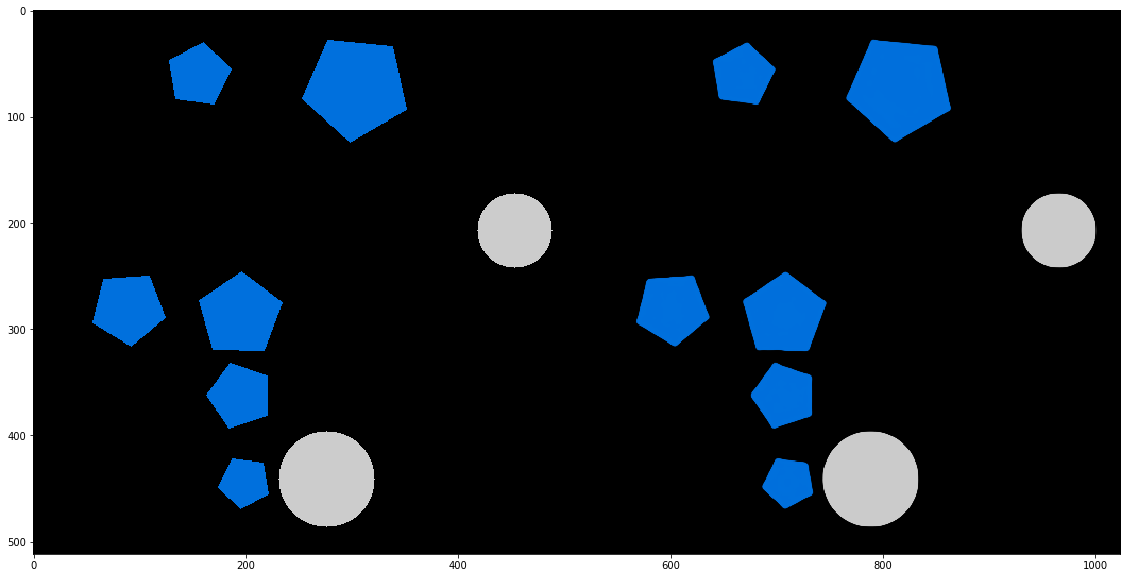

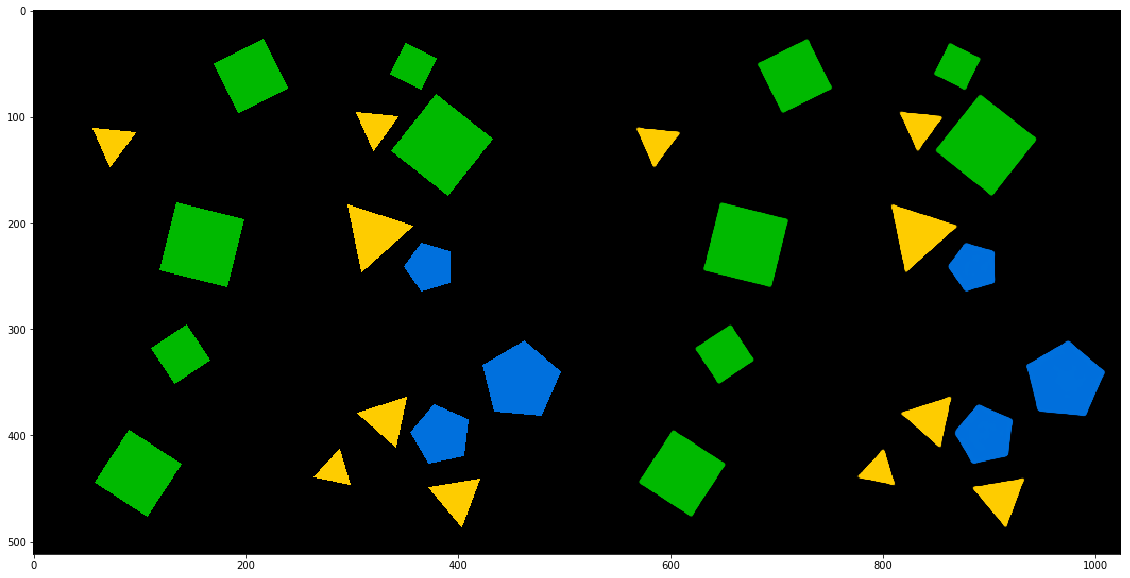

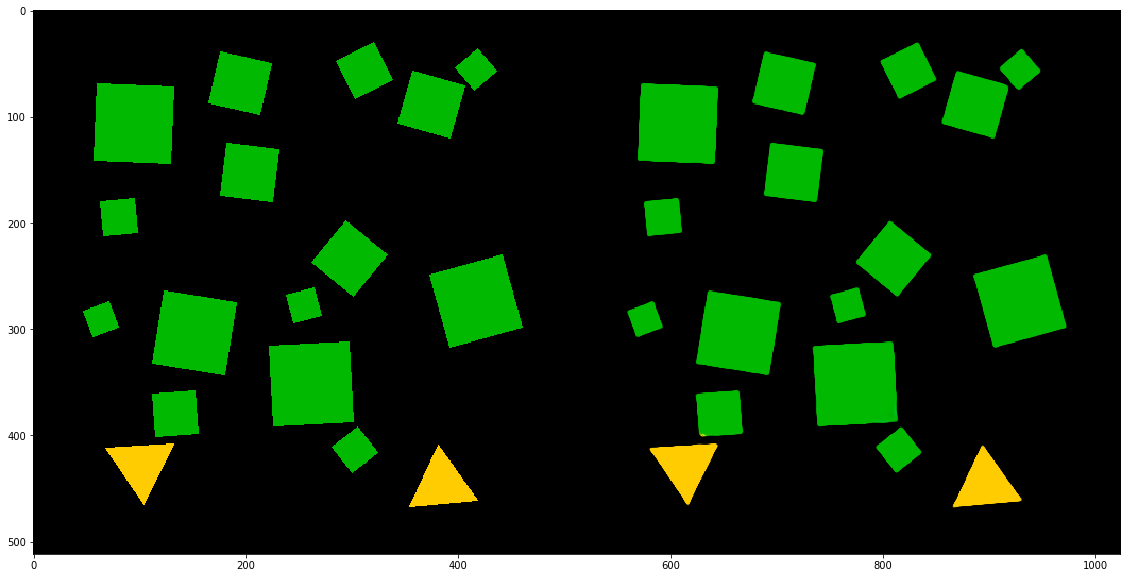

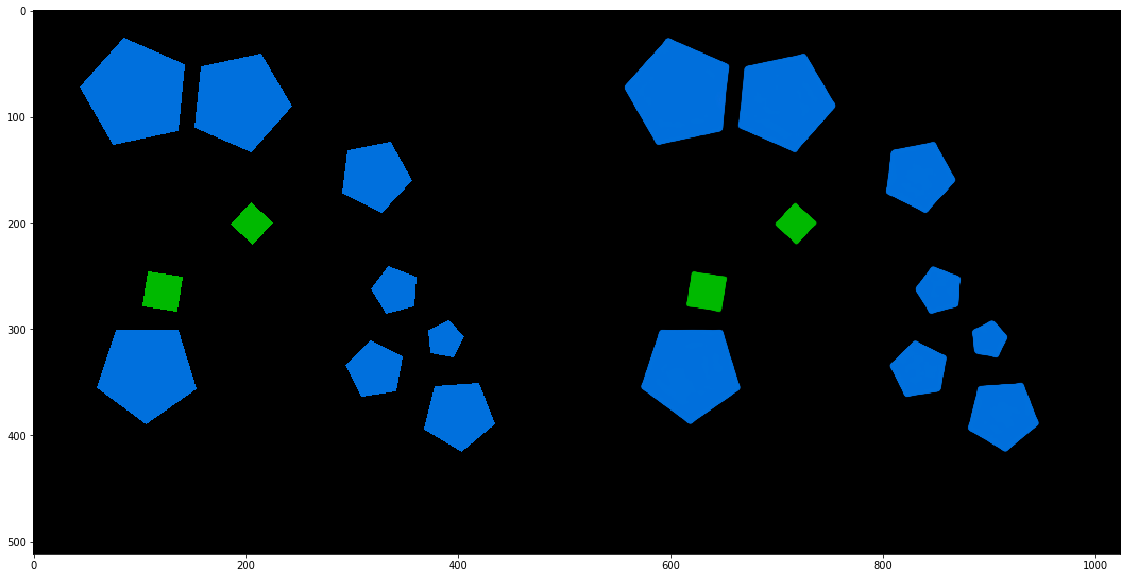

In [26]:
X, Y = next(test_generator)

t0 = time.time()
Ypred = 255.*model.predict(X)
t1 = time.time()

print('[INFO] Time delta is %.4f' % (t1 - t0, ))

for i in range(Ypred.shape[0]):
    x, y, ypred, ymask, ymaskpred = 255.*X[i,:,:,0], 255.*Y[i], Ypred[i], 0, 0

    for j in range(FIGURES_SHAPES_COUNT+1):
        color = colors[j]
        ymask|=(color*y[:,:,j:j+1]).astype(np.uint8)
        ymaskpred|=(color*ypred[:,:,j:j+1]).astype(np.uint8)

    im = np.hstack((ymask, ymaskpred))
    plt.figure(figsize=(20, 10))
    plt.imshow(im)
    plt.show()
    plt.clf()

Each test sample shows **ground truth** on the **left** and **prediction** on the **right**. Each channel is asigned a color in order to make visualization easier.